In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

from xgboost import XGBRegressor
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2

%matplotlib inline

### Data
---

In [2]:
df = pd.read_csv('./data/combined.csv')

In [3]:
df.head()

date                county   maxtempF   mintempF   avgtempF  totalSnow  \
0  2008-07  Santa Barbara County  89.129032  59.709677  80.548387        0.0   
1  2008-07      Calaveras County  96.419355  51.290323  87.032258        0.0   
2  2008-07      Calaveras County  96.419355  51.290323  87.032258        0.0   
3  2008-07      Calaveras County  96.419355  51.290323  87.032258        0.0   
4  2008-07      Calaveras County  96.419355  51.290323  87.032258        0.0   

       humid      wind  precip  q_avgtempF  q_avghumid  q_sumprecip  \
0  41.451613  7.354839     0.0   72.937634   34.079570     0.010000   
1  33.580645  5.387097     0.0   65.217204   38.434409     0.068065   
2  33.580645  5.387097     0.0   65.217204   38.434409     0.068065   
3  33.580645  5.387097     0.0   65.217204   38.434409     0.068065   
4  33.580645  5.387097     0.0   65.217204   38.434409     0.068065   

     sunHour       FIRE_NAME  CAUSE    lat    long   GIS_ACRES  
0  13.164516         no_fire    0.0  34.54 -120.04    0.000000  
1  14.022581      SERPENTINE    1.0  38.18 -120.56  176.763400  
2  14.022581  POOL 2 - MAIN    10.0  38.18 -120.56   73.444778  
3  14.022581          FRENCH   14.0  38.18 -120.56  101.074150  
4  14.022581           EVANS    6.0  38.18 -120.56  103.968050

In [4]:
df = df.drop(columns=['FIRE_NAME', 'lat', 'long'])

In [5]:
df['bool'] = (df['GIS_ACRES'] > 0) * 1

In [6]:
df['date'] = [x.split('-') for x in df['date']]

In [7]:
df['year'] = [int(x[0]) for x in df['date']]

In [8]:
df['month'] = [int(x[1]) for x in df['date']]

In [9]:
df.shape

(10988, 18)

In [10]:
df_dummy = pd.get_dummies(df, columns=['month'])

In [11]:
# test = ['2008', '07']
# datetime.datetime(int(test[0]), int(test[1]), 1).timestamp()

In [12]:
df_dummy.head()

date                county   maxtempF   mintempF   avgtempF  \
0  [2008, 07]  Santa Barbara County  89.129032  59.709677  80.548387   
1  [2008, 07]      Calaveras County  96.419355  51.290323  87.032258   
2  [2008, 07]      Calaveras County  96.419355  51.290323  87.032258   
3  [2008, 07]      Calaveras County  96.419355  51.290323  87.032258   
4  [2008, 07]      Calaveras County  96.419355  51.290323  87.032258   

   totalSnow      humid      wind  precip  q_avgtempF  ...  month_3  month_4  \
0        0.0  41.451613  7.354839     0.0   72.937634  ...        0        0   
1        0.0  33.580645  5.387097     0.0   65.217204  ...        0        0   
2        0.0  33.580645  5.387097     0.0   65.217204  ...        0        0   
3        0.0  33.580645  5.387097     0.0   65.217204  ...        0        0   
4        0.0  33.580645  5.387097     0.0   65.217204  ...        0        0   

   month_5  month_6  month_7  month_8  month_9  month_10  month_11  month_12  
0        0        0        1        0        0         0         0         0  
1        0        0        1        0        0         0         0         0  
2        0        0        1        0        0         0         0         0  
3        0        0        1        0        0         0         0         0  
4        0        0        1        0        0         0         0         0  

[5 rows x 29 columns]

In [13]:
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10988 entries, 0 to 10987
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         10988 non-null  object 
 1   county       10988 non-null  object 
 2   maxtempF     10988 non-null  float64
 3   mintempF     10988 non-null  float64
 4   avgtempF     10988 non-null  float64
 5   totalSnow    10988 non-null  float64
 6   humid        10988 non-null  float64
 7   wind         10988 non-null  float64
 8   precip       10988 non-null  float64
 9   q_avgtempF   10988 non-null  float64
 10  q_avghumid   10988 non-null  float64
 11  q_sumprecip  10988 non-null  float64
 12  sunHour      10988 non-null  float64
 13  CAUSE        10988 non-null  float64
 14  GIS_ACRES    10988 non-null  float64
 15  bool         10988 non-null  int32  
 16  year         10988 non-null  int64  
 17  month_1      10988 non-null  uint8  
 18  month_2      10988 non-null  uint8  
 19  mont

In [14]:
df_dummy.head()

date                county   maxtempF   mintempF   avgtempF  \
0  [2008, 07]  Santa Barbara County  89.129032  59.709677  80.548387   
1  [2008, 07]      Calaveras County  96.419355  51.290323  87.032258   
2  [2008, 07]      Calaveras County  96.419355  51.290323  87.032258   
3  [2008, 07]      Calaveras County  96.419355  51.290323  87.032258   
4  [2008, 07]      Calaveras County  96.419355  51.290323  87.032258   

   totalSnow      humid      wind  precip  q_avgtempF  ...  month_3  month_4  \
0        0.0  41.451613  7.354839     0.0   72.937634  ...        0        0   
1        0.0  33.580645  5.387097     0.0   65.217204  ...        0        0   
2        0.0  33.580645  5.387097     0.0   65.217204  ...        0        0   
3        0.0  33.580645  5.387097     0.0   65.217204  ...        0        0   
4        0.0  33.580645  5.387097     0.0   65.217204  ...        0        0   

   month_5  month_6  month_7  month_8  month_9  month_10  month_11  month_12  
0        0        0        1        0        0         0         0         0  
1        0        0        1        0        0         0         0         0  
2        0        0        1        0        0         0         0         0  
3        0        0        1        0        0         0         0         0  
4        0        0        1        0        0         0         0         0  

[5 rows x 29 columns]

### Classification
---

In [15]:
X = df_dummy.drop(columns=['GIS_ACRES', 'date', 'q_avgtempF', 'q_avghumid', 'q_sumprecip', 'maxtempF', 'mintempF', 'CAUSE', 'bool', 'county',"year","month_1","month_2","month_3","month_4","month_5","month_6","month_7","month_8","month_9","month_10","month_11","month_12","sunHour"])
y = df_dummy['bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
X_test.to_csv("./test.csv",index=False)

In [16]:
X

avgtempF  totalSnow      humid      wind    precip
0      80.548387   0.000000  41.451613  7.354839  0.000000
1      87.032258   0.000000  33.580645  5.387097  0.000000
2      87.032258   0.000000  33.580645  5.387097  0.000000
3      87.032258   0.000000  33.580645  5.387097  0.000000
4      87.032258   0.000000  33.580645  5.387097  0.000000
...          ...        ...        ...       ...       ...
10983  53.838710   0.000000  71.258065  6.870968  0.025806
10984  31.741935   0.501651  72.516129  2.774194  0.151613
10985  55.677419   0.000000  61.935484  3.483871  0.045161
10986  50.032258   0.000000  54.258065  3.774194  0.087097
10987  53.258065   0.000000  55.838710  5.741935  0.041935

[10988 rows x 5 columns]

In [17]:
df['bool'].value_counts(normalize=True)

0    0.638424
1    0.361576
Name: bool, dtype: float64

In [18]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
print(log_reg.score(X_train, y_train))
log_reg.score(X_test, y_test)

0.7303341568066571


0.7264179557173188

In [19]:
pd.set_option('display.max_row', None)

In [20]:
coef_df = pd.DataFrame(log_reg.coef_, columns=X.columns)
coef_df.T.sort_values(by=0, ascending=False).head(77)

0
totalSnow  0.505568
avgtempF   0.064710
humid     -0.010216
wind      -0.249564
precip    -3.203189

In [21]:
log_reg.coef_

array([[ 0.06471038,  0.50556776, -0.01021609, -0.24956396, -3.20318852]])

In [22]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [23]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(X_train_sc, y_train)
print(knn.score(X_train_sc, y_train))
knn.score(X_test_sc, y_test)

0.9981796905473931


0.8292387018501668

In [24]:
rf = RandomForestClassifier(n_estimators=150, max_depth=15)
rf.fit(X_train, y_train)

# save the model to disk
filename = 'randomforest.sav'
pickle.dump(rf, open(filename, 'wb'))

# some time later...

# load the model from disk
rf = pickle.load(open(filename, 'rb'))


print(rf.score(X_train, y_train))
rf.score(X_test, y_test)

0.9824470159927188


0.86472550803761

In [25]:
rf_preds = rf.predict(X_test)
rf_preds

array([1, 0, 0, ..., 0, 0, 0])

In [26]:
rf.feature_importances_

array([0.35848872, 0.02320638, 0.27932743, 0.19545657, 0.1435209 ])

In [27]:
feature_df = pd.DataFrame(rf.feature_importances_, index=X.columns)
feature_df.sort_values(by=0, ascending=False)

0
avgtempF   0.358489
humid      0.279327
wind       0.195457
precip     0.143521
totalSnow  0.023206

In [28]:
log_reg.predict(X_test)
knn.predict(X_test)
rf.predict(X_test)

array([1, 0, 0, ..., 0, 0, 0])

In [29]:
pred_df = pd.DataFrame(columns=['log_reg', 'knn', 'rf'])
pred_df['log_reg'] = log_reg.predict(X_test)
pred_df['knn'] = knn.predict(X_test)
pred_df['rf'] = rf.predict(X_test)
pred_df['ensemble'] = (pred_df.sum(axis=1)/3).round(0)
pred_df.head()

log_reg  knn  rf  ensemble
0        1    0   1       1.0
1        0    0   0       0.0
2        0    0   0       0.0
3        0    0   1       0.0
4        0    0   0       0.0

In [30]:
metrics.accuracy_score(pred_df['ensemble'], y_test)

0.7667576584774037

In [31]:
knn_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=3, weights='distance')),
])

vote = VotingClassifier([
    ('knn_pipe', knn_pipe),
    ('rf', RandomForestClassifier(n_estimators=150, max_depth=15)),
    ('ada', AdaBoostClassifier(n_estimators=150))
])

vote.fit(X_train, y_train)

VotingClassifier(estimators=[('knn_pipe',
                              Pipeline(steps=[('sc', StandardScaler()),
                                              ('knn',
                                               KNeighborsClassifier(n_neighbors=3,
                                                                    weights='distance'))])),
                             ('rf',
                              RandomForestClassifier(max_depth=15,
                                                     n_estimators=150)),
                             ('ada', AdaBoostClassifier(n_estimators=150))])

In [32]:
print(f"Train Score:\t{vote.score(X_train, y_train):.4f}")
print(f"Test Score:\t{vote.score(X_test, y_test):.4f}")

Train Score:	0.9836
Test Score:	0.8553


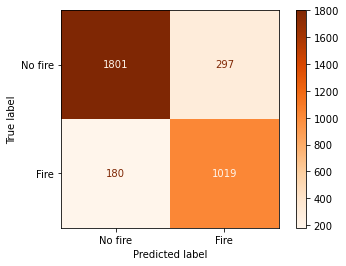

In [33]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, vote.predict(X_test)).ravel()
metrics.plot_confusion_matrix(vote, X_test, y_test, cmap='Oranges', display_labels=['No fire', 'Fire']);

In [34]:
vote_preds = vote.predict(X_test)

In [35]:
metrics.roc_auc_score(y_test, rf_preds)
print(metrics.recall_score(y_test, rf_preds))
print(metrics.precision_score(y_test, rf_preds))

0.8331943286071727
0.8024096385542169


In [36]:
metrics.roc_auc_score(y_test, vote_preds)
print(metrics.recall_score(y_test, vote_preds))
print(metrics.precision_score(y_test, vote_preds))

0.8498748957464554
0.7743161094224924


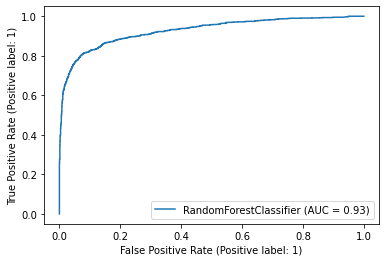

In [37]:
metrics.plot_roc_curve(rf, X_test, y_test);

In [38]:
n_input = X_train.shape[1]

model = Sequential()
model.add(BatchNormalization())
model.add(Dense(128, input_shape=(n_input,), activation='relu'))
model.add(Dropout(.05))
model.add(Dense(256, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='bce', optimizer='adam', metrics=['acc', 'Recall', 'Precision'])

# early_stop = EarlyStopping(monitor='val_loss', patience=, verbose=1)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128, verbose=1)

model.evaluate(X_test, y_test)

Epoch 1/100
61/61 [==============================] - 2s 13ms/step - loss: 0.5305 - acc: 0.7298 - recall: 0.6723 - precision: 0.6147 - val_loss: 0.5222 - val_acc: 0.7249 - val_recall: 0.5288 - val_precision: 0.6496
Epoch 2/100
61/61 [==============================] - 0s 5ms/step - loss: 0.5069 - acc: 0.7374 - recall: 0.6687 - precision: 0.6275 - val_loss: 0.5289 - val_acc: 0.7179 - val_recall: 0.4921 - val_precision: 0.6476
Epoch 3/100
61/61 [==============================] - 0s 5ms/step - loss: 0.5035 - acc: 0.7418 - recall: 0.6510 - precision: 0.6395 - val_loss: 0.5321 - val_acc: 0.7322 - val_recall: 0.6347 - val_precision: 0.6310
Epoch 4/100
61/61 [==============================] - 0s 5ms/step - loss: 0.4982 - acc: 0.7436 - recall: 0.6438 - precision: 0.6448 - val_loss: 0.5057 - val_acc: 0.7352 - val_recall: 0.5746 - val_precision: 0.6549
Epoch 5/100
61/61 [==============================] - 0s 5ms/step - loss: 0.4977 - acc: 0.7450 - recall: 0.6536 - precision: 0.6445 - val_loss: 0.49

61/61 [==============================] - 0s 5ms/step - loss: 0.4608 - acc: 0.7756 - recall: 0.7185 - precision: 0.6784 - val_loss: 0.4652 - val_acc: 0.7774 - val_recall: 0.6822 - val_precision: 0.6985
Epoch 40/100
61/61 [==============================] - 0s 4ms/step - loss: 0.4621 - acc: 0.7726 - recall: 0.6781 - precision: 0.6872 - val_loss: 0.4638 - val_acc: 0.7831 - val_recall: 0.7073 - val_precision: 0.6997
Epoch 41/100
61/61 [==============================] - 0s 4ms/step - loss: 0.4650 - acc: 0.7708 - recall: 0.6957 - precision: 0.6774 - val_loss: 0.4613 - val_acc: 0.7874 - val_recall: 0.7131 - val_precision: 0.7054
Epoch 42/100
61/61 [==============================] - 0s 5ms/step - loss: 0.4579 - acc: 0.7771 - recall: 0.7094 - precision: 0.6843 - val_loss: 0.4606 - val_acc: 0.7810 - val_recall: 0.7223 - val_precision: 0.6900
Epoch 43/100
61/61 [==============================] - 0s 5ms/step - loss: 0.4601 - acc: 0.7727 - recall: 0.6911 - precision: 0.6827 - val_loss: 0.4623 - val_

61/61 [==============================] - 0s 6ms/step - loss: 0.4445 - acc: 0.7839 - recall: 0.6986 - precision: 0.7012 - val_loss: 0.4555 - val_acc: 0.7856 - val_recall: 0.7273 - val_precision: 0.6965
Epoch 78/100
61/61 [==============================] - 0s 6ms/step - loss: 0.4416 - acc: 0.7881 - recall: 0.7040 - precision: 0.7071 - val_loss: 0.4640 - val_acc: 0.7819 - val_recall: 0.7573 - val_precision: 0.6796
Epoch 79/100
61/61 [==============================] - 0s 4ms/step - loss: 0.4445 - acc: 0.7874 - recall: 0.7073 - precision: 0.7045 - val_loss: 0.4525 - val_acc: 0.7868 - val_recall: 0.7164 - val_precision: 0.7029
Epoch 80/100
61/61 [==============================] - 0s 4ms/step - loss: 0.4521 - acc: 0.7797 - recall: 0.7004 - precision: 0.6924 - val_loss: 0.4566 - val_acc: 0.7753 - val_recall: 0.6063 - val_precision: 0.7299
Epoch 81/100
61/61 [==============================] - 0s 4ms/step - loss: 0.4471 - acc: 0.7807 - recall: 0.6810 - precision: 0.7020 - val_loss: 0.4635 - val_

[0.4598051607608795,
 0.7873824834823608,
 0.7823185920715332,
 0.6806966662406921]

In [39]:
history_df = pd.DataFrame(history.history)
history_df.sort_values(by='acc', ascending=False)

loss       acc    recall  precision  val_loss   val_acc  val_recall  \
88  0.439623  0.791315  0.716294   0.708378  0.455275  0.787382    0.745621   
97  0.439206  0.788714  0.731795   0.697355  0.453636  0.785563    0.758132   
94  0.441432  0.788454  0.721702   0.700735  0.451956  0.786169    0.714762   
77  0.441591  0.788064  0.704037   0.707096  0.464034  0.781923    0.757298   
78  0.444499  0.787414  0.707282   0.704488  0.452541  0.786776    0.716430   
85  0.444251  0.786764  0.701514   0.705584  0.455136  0.782530    0.703920   
86  0.442065  0.786764  0.680606   0.714610  0.457420  0.784046    0.748123   
82  0.446075  0.786504  0.701154   0.705221  0.454524  0.781923    0.672227   
74  0.444948  0.786374  0.705119   0.703344  0.454370  0.786776    0.738949   
95  0.442282  0.786244  0.716655   0.698524  0.452685  0.787686    0.690575   
69  0.447294  0.786114  0.702596   0.703864  0.455384  0.787079    0.736447   
92  0.443458  0.785464  0.715934   0.697331  0.453871  0.787989    0.718932   
52  0.452944  0.785464  0.706200   0.701145  0.459686  0.777677    0.693912   
91  0.444833  0.785073  0.703677   0.701401  0.455221  0.786473    0.759800   
98  0.439916  0.784683  0.703677   0.700646  0.452576  0.788596    0.726439   
87  0.441270  0.784423  0.706921   0.698860  0.458078  0.781620    0.714762   
90  0.445942  0.784293  0.687094   0.706711  0.454274  0.790416    0.717264   
75  0.448794  0.784163  0.714492   0.695439  0.453899  0.793449    0.731443   
76  0.444500  0.783903  0.698630   0.701158  0.455464  0.785563    0.727273   
93  0.440492  0.783773  0.699712   0.700469  0.450389  0.789202    0.676397   
99  0.442947  0.783383  0.707282   0.696733  0.459805  0.787382    0.782319   
81  0.449238  0.782863  0.711247   0.694229  0.457374  0.785563    0.712260   
72  0.451155  0.782603  0.705840   0.695807  0.456584  0.784956    0.703920   
62  0.449375  0.782473  0.710526   0.693770  0.457704  0.783136    0.723937   
66  0.450196  0.782473  0.692141   0.700986  0.457073  0.790719    0.734779   
64  0.447135  0.782343  0.697188   0.698699  0.460982  0.786473    0.754796   
96  0.442579  0.782083  0.698630   0.697624  0.451281  0.789506    0.705588   
84  0.443135  0.781563  0.714131   0.690725  0.453408  0.788899    0.694746   
61  0.451406  0.781303  0.704398   0.693892  0.459086  0.785259    0.728941   
59  0.453644  0.781303  0.711968   0.691043  0.459927  0.786473    0.702252   
68  0.449693  0.780783  0.699712   0.694703  0.455228  0.786473    0.733111   
55  0.451491  0.780653  0.705119   0.692389  0.457663  0.783136    0.722269   
80  0.447106  0.780653  0.680966   0.701970  0.463515  0.782833    0.756464   
47  0.457971  0.780653  0.692862   0.697135  0.455717  0.784653    0.719766   
89  0.445502  0.780523  0.701514   0.693514  0.456102  0.778283    0.663887   
58  0.450184  0.780393  0.703677   0.692444  0.459694  0.781316    0.698082   
71  0.449716  0.780263  0.689257   0.697810  0.455509  0.783440    0.773978   
70  0.450058  0.780133  0.710526   0.689402  0.453915  0.783440    0.679733   
79  0.452094  0.779743  0.700433   0.692445  0.456596  0.775250    0.606339   
83  0.441613  0.779092  0.686734   0.696527  0.452815  0.786169    0.719766   
43  0.455521  0.778442  0.698630   0.690663  0.462544  0.784046    0.700584   
63  0.449969  0.778442  0.694304   0.692308  0.458798  0.781923    0.693078   
51  0.452976  0.778312  0.693223   0.692474  0.459418  0.783743    0.728107   
56  0.449347  0.778182  0.697549   0.690578  0.458796  0.785563    0.728107   
48  0.456544  0.777402  0.713771   0.683230  0.456888  0.785866    0.740617   
41  0.457890  0.777142  0.709445   0.684284  0.460639  0.781013    0.722269   
65  0.453147  0.777012  0.712329   0.683028  0.456341  0.786776    0.711426   
60  0.456349  0.777012  0.702235   0.686641  0.459376  0.779193    0.709758   
44  0.461455  0.776752  0.697188   0.688011  0.462626  0.782226    0.773978   
67  0.453236  0.776622  0.709805   0.683206  0.455744  0.7

In [40]:
X_test

avgtempF  totalSnow      humid       wind    precip
107     80.032258   0.000000  52.677419   4.322581  0.022581
8248    60.741935   0.000000  53.806452   5.193548  0.103226
7091    53.533333   0.000000  70.733333   3.666667  0.170000
7487    75.866667   0.000000  52.300000   7.133333  0.000000
6300    50.548387   0.000000  80.322581   6.064516  0.151613
9144    48.612903   0.000000  66.580645   3.935484  0.158065
7528    98.033333   0.000000  12.766667   4.966667  0.000000
5646    48.933333   0.057743  64.433333   4.833333  0.076667
1718    77.000000   0.000000  49.806452   4.193548  0.006452
3721    38.600000   0.144357  80.900000   6.200000  0.273333
3160    58.225806   0.000000  66.548387   4.709677  0.038710
5968    76.290323   0.000000  59.064516   4.903226  0.000000
2407    69.967742   0.000000  63.580645   6.677419  0.006452
9557    62.741935   0.000000  80.193548   9.870968  0.000000
5025    78.548387   0.000000  56.129032   5.838710  0.000000
7615    89.161290   0.000000  33.354839   4.774194  0.000000
7191    48.129032   0.000000  82.225806   6.516129  0.200000
398     46.612903   0.000000  70.387097   5.451613  0.048387
10957   49.419355   0.000000  60.032258   3.548387  0.058065
6753    75.645161   0.000000  41.903226   4.193548  0.000000
5853    73.161290   0.000000  60.322581   3.225806  0.048387
960     83.354839   0.000000  23.129032   4.838710  0.000000
5659    66.258065   0.000000  64.903226   5.419355  0.016129
1617    76.032258   0.000000  54.354839   4.935484  0.003226
4693    49.357143   0.000000  84.892857   7.857143  0.417857
8292    51.741935   0.000000  73.322581   3.516129  0.187097
694     75.838710   0.000000  37.161290   5.548387  0.003226
740     68.033333   0.000000  53.466667   6.166667  0.023333
5337    60.300000   0.000000  48.666667   3.600000  0.043333
5007    70.225806   0.000000  42.290323   4.709677  0.141935
7436    72.516129   0.000000  52.483871   6.419355  0.006452
10106   55.321429   0.000000  57.107143   5.071429  0.003571
2534    90.806452   0.000000  18.483871   8.806452  0.016129
10293   64.933333   0.038058  47.300000   5.700000  0.013333
9068    60.233333   0.000000  42.700000   5.666667  0.126667
2998    49.821429   0.000000  59.571429   6.000000  0.050000
10097   64.392857   0.000000  30.607143   5.964286  0.007143
2791    55.000000   0.000000  39.400000   6.833333  0.016667
6791    81.709677   0.000000  46.774194   4.580645  0.000000
1691    73.612903   0.000000  62.290323   5.258065  0.003226
5532    59.857143   0.000000  62.500000   5.535714  0.064286
747     72.033333   0.000000  53.666667   4.733333  0.010000
8390    65.258065   0.000000  31.419355   6.774194  0.012903
10055   62.857143   0.000000  37.285714   4.142857  0.007143
2487    76.000000   0.000000  59.516129   4.161290  0.003226
7608    78.935484   0.000000  53.000000   4.774194  0.009677
8470    50.233333   0.712598  68.000000   4.966667  0.163333
1121    63.466667   0.000000  42.000000   5.466667  0.006667
2388    67.800000   0.000000  59.433333   5.700000  0.140000
4047    69.548387   0.000000  52.935484   7.129032  0.016129
533     47.071429   0.000000  81.035714   6.357143  0.564286
10646   98.225806   0.000000  24.064516   5.580645  0.000000
3247    75.300000   0.000000  46.166667   6.366667  0.043333
3941    64.161290   0.000000  52.000000   6.516129  0.074194
6998    47.096774   0.375921  55.612903   5.354839  0.251613
5176    65.666667   0.000000  79.000000   6.900000  0.010000
1213    44.129032   0.000000  69.419355   5.387097  0.158065
4984    93.709677   0.000000  31.032258   5.387097  0.006452
8486    56.806452   0.064770  65.548387   4.451613  0.306452
10077   48.821429   0.012655  52.857143   5.642857  0.003571
251     63.225806   0.000000  61.129032   7.677419  0.009677
9559    67.870968   0.000000  40.322581   5.677419  0.009677
10341   77.300000   0.000000  44.100000   4.866667  0.023333
3914    46.548387   0.153670  75.645161   4.129032  0.129032
33      75.774194   0.000000  49.645161   7.

In [41]:
model.save("./keras.h5")
Model = keras.models.load_model("./keras.h5")

In [42]:
Model.evaluate(X_test, y_test)

104/104 [==============================] - 0s 1ms/step - loss: 0.4598 - acc: 0.7874 - recall: 0.7823 - precision: 0.6807


[0.4598051607608795,
 0.7873824834823608,
 0.7823185920715332,
 0.6806966662406921]